# Links
https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/agent_supervisor.ipynb \
https://python.langchain.com/docs/integrations/tools/tavily_search/ \
https://tavily.com/ \
https://python.langchain.com/docs/integrations/chat/openai/

In [1]:
#%%capture --no-stderr
#%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental
#%pip install -U langchain-openai

In [2]:
import getpass
import os
from dotenv import load_dotenv


def _set_if_undefined(var: str):
    if not os.getenv(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")
        #print("API key error")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

## Create Tools

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str 

## Create Agent Supervisor

In [4]:
from typing import Literal
from typing_extensions import TypedDict

#from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["doubler", "texter"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

## Construct Graph

In [8]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


double_agent = create_react_agent(
    llm, tools=[], prompt="You are a doubler. Double the number given (integer). Say what you input was and your result."
)


def double_node(state: State) -> Command[Literal["supervisor"]]:
    result = double_agent.invoke(state)
    

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doubler")
            ]
        },
        goto="texter",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
#code_agent = create_react_agent(llm, tools=[python_repl_tool])

texter_agent = create_react_agent(
    llm, tools=[], prompt="You convert the output of the doubler (integer) to text. Do not convert human input to text. Say what your input was and then its double in text and only deal with numbers and not the entire output of the doubler."
)


def text_node(state: State) -> Command[Literal["supervisor"]]:
    result = texter_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="texter")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("doubler", double_node)
builder.add_node("texter", text_node)
graph = builder.compile()

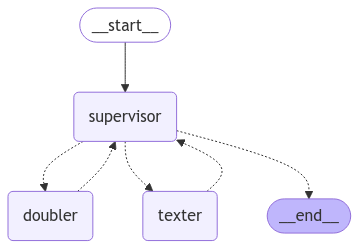

In [9]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

In [10]:
for s in graph.stream(
    {"messages": [("user", "7")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'doubler'}})
----
(('doubler:6874fb4a-e18b-1609-c11f-50c44736ae91',), {'agent': {'messages': [AIMessage(content='You input was 7, and the result is 14.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 34, 'total_tokens': 48, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-cdf879c9-da62-4af2-aece-45e2350a34ac-0', usage_metadata={'input_tokens': 34, 'output_tokens': 14, 'total_tokens': 48, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}})
----
((), {'doubler': {'messages': [HumanMessage(content='You input was 7, and the result is 14.', additional_kwargs